In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences=requests.get(SEQUENCES_URL).text.split("\n")
sequences=list(filter(None,sequences))

pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

integer_encoder=LabelEncoder()
one_hot_encoder=OneHotEncoder(categories="auto")
input_features=[]

for sequence in sequences:
  integer_encoded=integer_encoder.fit_transform(list(sequence))
  integer_encoded=np.array(integer_encoded).reshape(-1,1)
  one_hot_encoded=one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())


np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels=requests.get(LABELS_URL).text.split("\n")
labels=list(filter(None, labels))

one_hot_encoder=OneHotEncoder(categories="auto")
labels=np.array(labels).reshape(-1,1)
input_labels=one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [5]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels=train_test_split(input_features,
                                                                          input_labels, test_size=0.25, random_state=42)

In [8]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12,
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 32)            1568      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 16)                4624      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
______________________________________________________

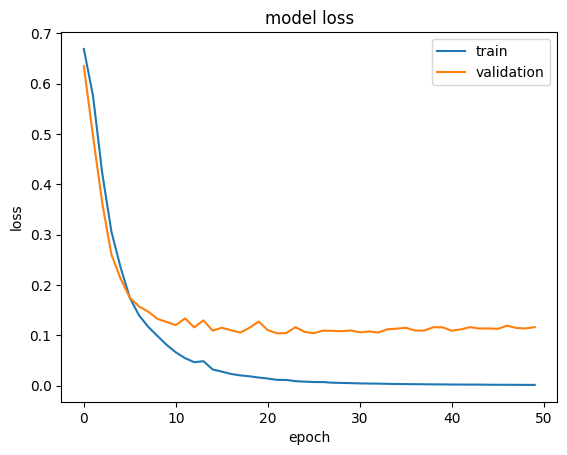

In [9]:
history=model.fit(train_features, train_labels,
                  epochs=50, verbose=0,
                  validation_split=0.25)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

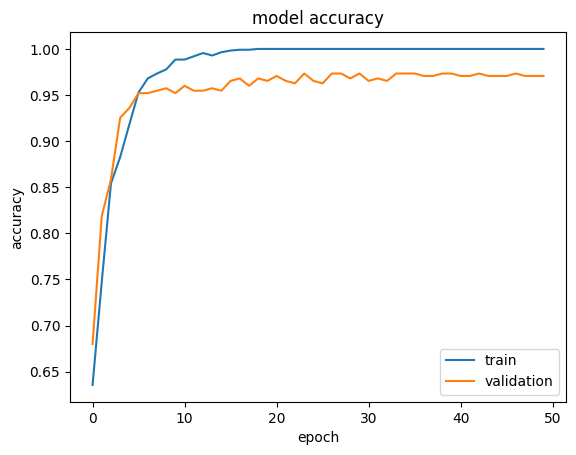

In [10]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

16/16 [==============================] - 0s 1ms/step
Confusion matrix:
 [[249  10]
 [  2 239]]


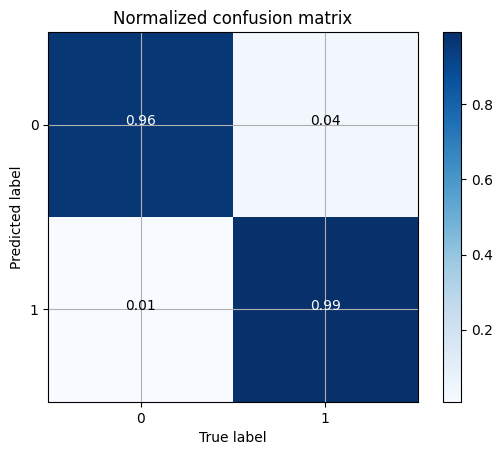

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels=model.predict(np.stack(test_features))
cm=confusion_matrix(np.argmax(test_labels, axis=1),
                    np.argmax(predicted_labels,axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

Text(0.5, 1.0, 'Saliency map for bases in one of the positive sequences (orange indicates the actual bases in motif)')

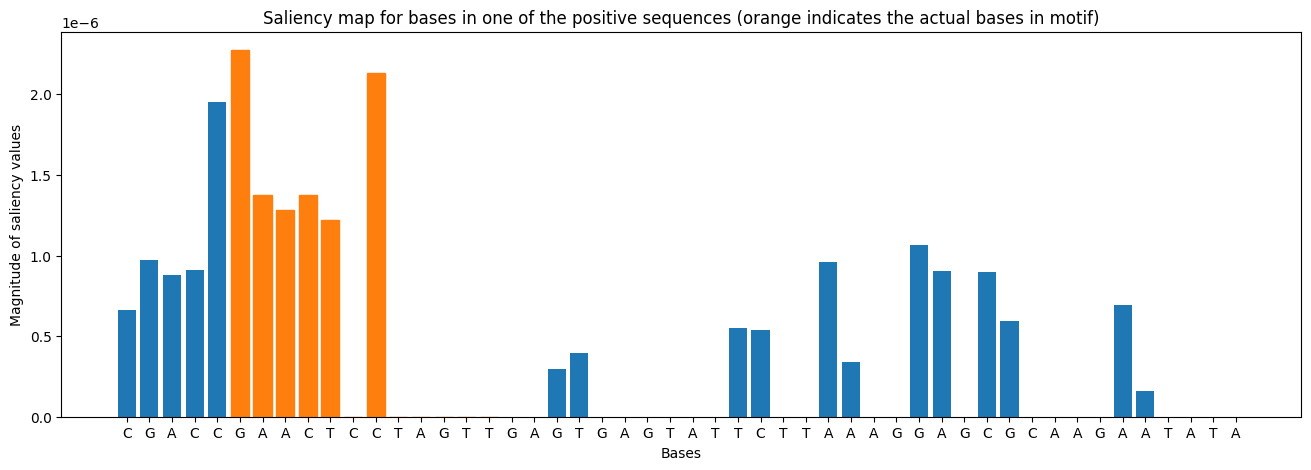

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def compute_salient_bases(model, x):
  with tf.GradientTape() as tape:
    # Watch the input x
    tape.watch(x)
    # Compute the prediction of the model
    predictions = model(x)
    # You may need to adapt the following line if your model has a different output shape
    class_idx = tf.argmax(predictions[0])
    output_to_use = predictions[:, class_idx]

  # Compute gradients with respect to the watched tensor
  gradients = tape.gradient(output_to_use, x)

  # Post-process the gradients
  x_value = np.expand_dims(x, axis=0)
  gradients = gradients.numpy()[0]  # Assuming a batch size of 1
  sal = np.clip(np.sum(np.multiply(gradients, x_value), axis=1), a_min=0, a_max=None)
  return sal


sequence_index = 1000
x_input = input_features[sequence_index]
x_input = np.expand_dims(x_input, axis=0)  # Make it a batch of 1

sal = compute_salient_bases(model, tf.convert_to_tensor(x_input, dtype=tf.float32))
sal = np.sum(sal, axis=-1).squeeze()

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (orange indicates the actual bases in motif)')
